In [1]:
%matplotlib inline
import sys
sys.path.append("..") # Adds the module to path

# Example 5. Multiparticle tracking in 3D

Trains a U-Net to locate spherical particles in 3d.

## 1. Setup

Imports and defines the objects needed for this example.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import skimage
import skimage.measure

import deeptrack as dt

import datasets

datasets.load("3DTracking")

video = scipy.io.loadmat(r"./datasets/3DTracking/1Every1_2_movie_1.aviProcessedField0.mat")
traces = scipy.io.loadmat(r"./datasets/3DTracking/1Every1_2_movie_1.aviCompletedTraces")
mapping = scipy.io.loadmat(r"./datasets/3DTracking/mapping.mat")["Mapping"]


IMAGE_SIZE = 128
MIN_Z = 2e-6
MAX_Z = 30e-6
Z_SCALE = 5e-7
PIXEL_SCALE = 3.45e-7

3DTracking already downloaded! Use force_overwrite=True to redownload the dataset.


## 2. Defining the dataset

Defining the optical device, with Coma aberration.

In [3]:
pupil = dt.HorizontalComa(coefficient=lambda: 2 +  3*np.random.rand()) + dt.VerticalComa(coefficient=lambda:-2 - np.random.rand()*2)

optics = dt.Brightfield(
    NA=1.3,
    wavelength=633e-9,
    magnification=1,
    resolution=lambda magnification: (PIXEL_SCALE * magnification,) * 2 + (Z_SCALE * magnification,),
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
    upscale=1,
    pupil=pupil
)

Defining the particles.

In [4]:
particles = dt.MieSphere(
    position=lambda: 20 + np.random.rand(2) * (IMAGE_SIZE - 40),
    z=lambda: + MIN_Z / Z_SCALE + (np.random.rand() * (MAX_Z / Z_SCALE - MIN_Z / Z_SCALE)),
    position_unit="pixel",
    refractive_index=lambda: 1.45 + np.random.rand() * 0.1,
    radius=lambda: 190e-9 + np.random.rand() * 100e-9,
)
particles = particles ** (lambda: np.random.randint(2, 8))

Adding noise, illumination gradient and normalization

In [5]:
noise = dt.Poisson(snr=lambda: 7 + np.random.rand() * 10, background=1)

gradient = dt.IlluminationGradient(gradient=lambda: np.random.randn(2)*0.0001)

normalization = dt.NormalizeMinMax(min=lambda:np.random.rand()*0.3, max=lambda min: min + 0.7 + np.random.rand()*0.3)

In [6]:
dataset = optics(particles) + noise + gradient + normalization

Visualizing the dataset

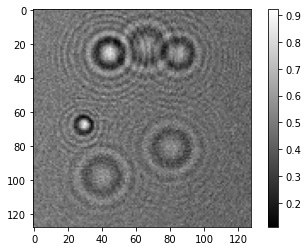

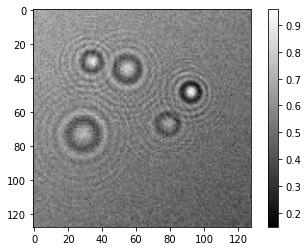

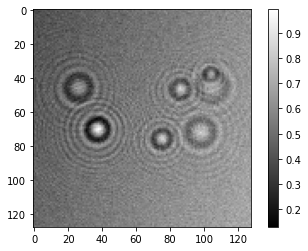

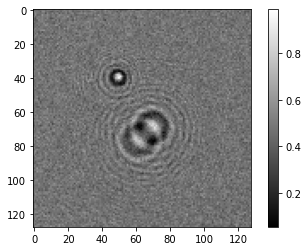

In [7]:
for _ in range(4):
    image = dataset.update().resolve()
    plt.imshow(image[:, :, 0], cmap="gray")
    plt.colorbar()
    plt.show()

## 3. Defining the target

We define the target as a 3D sphere, and use SampleToMasks to position the spheres.

In [8]:
number_of_features = int(MAX_Z / Z_SCALE -  MIN_Z / Z_SCALE)
radius = 5

X, Y, Z = np.mgrid[:radius*2, :radius*2, :radius*2]

SPHERE = (X-radius+0.5)**2 + (Y-radius+0.5)**2 + (Z-radius+0.5)**2 < radius**2

def mask(particle):  
    output = np.zeros((*SPHERE.shape[0:2], number_of_features))
    z = int(np.round(particle.get_property("z") -  MIN_Z / Z_SCALE))
    z0 = np.max([z, 0])
    zs0 = z0 - z
    z1 = np.min([z+SPHERE.shape[2], number_of_features])
    zs1 = z1 - z0
    output[:, :, z0:z1] = SPHERE[:, :, zs0:zs1]
    return output


label = dt.SampleToMasks(
    lambda: mask,
    number_of_masks=number_of_features,
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE)
)


def get_label(image):
    return label.update().resolve(image)

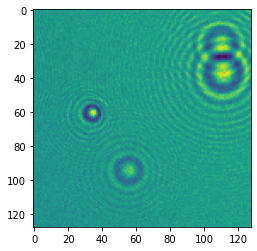

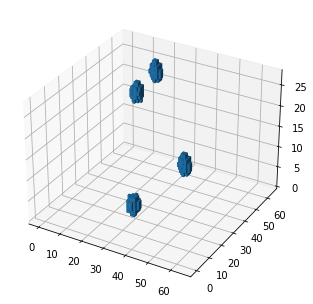

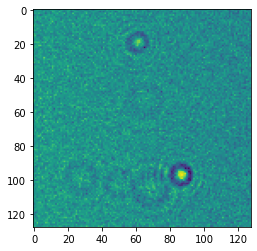

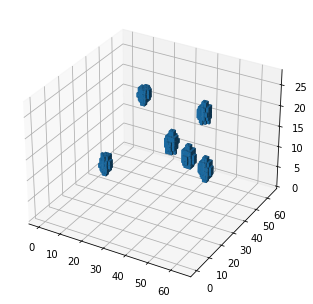

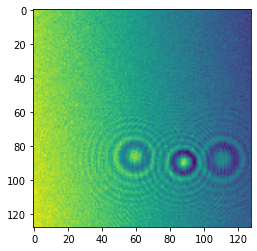

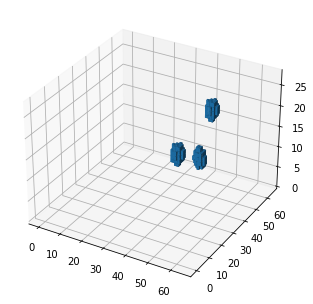

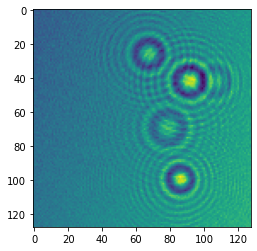

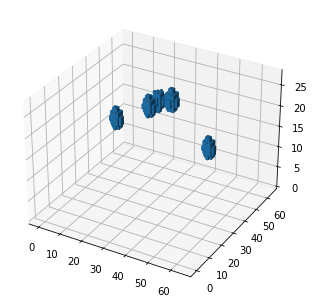

In [9]:
from mpl_toolkits.mplot3d import axes3d, Axes3D 

for _ in range(4):
    image = dataset.update().resolve()
    ground_truth = get_label(image)
    fig = plt.figure()
    plt.imshow(image[:, :, 0])
    fig = plt.figure()
    ax = Axes3D(fig)
    
    ax.voxels(ground_truth[::2, ::2, ::2])
    plt.show()

## 4. Defining the model

In [10]:
from deeptrack.models import unet
from deeptrack.losses import weighted_crossentropy, nd_mean_squared_error


weight = [20, 1]
model = unet(
    input_shape=(None, None, 1),
    steps_per_pooling=1,
    conv_layers_dimensions=(32, 64, 128,),
    base_conv_layers_dimensions=(128, 128),
    output_conv_layers_dimensions=(64, 64),
    loss=weighted_crossentropy(weight),
    output_activation="sigmoid",
    number_of_outputs=number_of_features,
    metrics=[weighted_crossentropy((1, 1))]
)

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 320         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, None, None, 3 0           activation[0][0]                 
_______________________________________________________________________________________

## 5. Training the model

In [11]:
TRAIN_MODEL = False

validation_data = []
validation_labels = []
for _ in range(256):
    val_image = dataset.update().resolve()
    val_label = get_label(val_image)
    validation_data.append(val_image)
    validation_labels.append(val_label)

    
validation_set = (
    np.array(validation_data),
    np.array(validation_labels),
)

if TRAIN_MODEL:
    generator = dt.generators.ContinuousGenerator(
        dataset,
        get_label,
        min_data_size=2000,
        max_data_size=4000,
        batch_size=32
    )

    with generator:

        h = model.fit(generator,
            epochs=100,
            validation_data=validation_set
        )
else:
    path = datasets.load_model("3DTracking")
    model.load_weights(path)

3DTracking already downloaded! Use force_overwrite=True to redownload the model.


## 6. Visualizing the results

We visualize the out of plane tracking be comparing the predicted z position of  single trace to that of the off-axis method.

We start by converting the processed fields into a list of images in the real space, and downsample them by a factor of three.

In [12]:
completed_traces = traces["CompletedTraces"]
processed_video = video["ProcessedField"][0]
# Transpose to account for matlab indexing
mapping = np.transpose(mapping)

vout = []
for idx, frame in enumerate(processed_video):
    
    im = np.zeros(mapping.shape) * 0j
    im[mapping > 0] = frame[:, 0]
    im = np.fft.ifft2(im)
    out = dt.AveragePooling(ksize=(3, 3)).update().resolve(np.abs(im + 1) ** 2, keep_size=False)    
    vout.append(out)

    if idx > 100:
        break
    
vout = np.array(vout)

We pick a single trace and compare the model and the off-axis results.

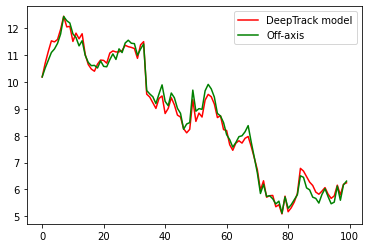

In [13]:


# Odd indexing due to how matlab tables are converted to python objects.
trace = completed_traces[0, 94]
trace = trace[0][0][1]

x = trace[:,1] / 0.115 / 3
y = trace[:,2] / 0.115 / 3
z = trace[:,3] 

predicted_z = []
positions = []
frames = []
for i in range(0, 100):

    try:
        t = int(trace[i, 0])

        frame = np.expand_dims(vout[i, :, :], axis=-1)
        frame -= np.min(frame)
        frame /= np.max(frame)

        frame = frame[int(x[i])-48:int(x[i])+48, int(y[i])-48:int(y[i])+48, :]

        frames.append(frame)
        outp = model.predict(np.array([frame])) > 0.9
        CC = skimage.measure.label(outp[0])
        props = skimage.measure.regionprops(CC)
        centroids = [prop["Centroid"] for prop in props]
        idx= np.argmin(np.sum(np.abs(np.array(centroids)[:, :2]-60), axis=1))
        
        predicted_z.append((centroids[idx][2] + MIN_Z / Z_SCALE) * Z_SCALE / 1e-6)
        
        c = np.array(centroids[idx])
        c[0] += x[i]
        c[1] += y[i]
        c[2] = (c[2] + MIN_Z / Z_SCALE) * Z_SCALE / 1e-6
        positions.append(c)

    except Exception as e:
        print(e)
        break

plt.plot(np.array(predicted_z), c="r")
# Multiply by 1.5 to account for refractive index mismatch between objective and slide.
plt.plot(z[:len(predicted_z)] * 1.5, c="g")

plt.legend(['DeepTrack model', 'Off-axis'])

plt.show()